# 人工知能特論2 課題 Deepfake Detection
CNN + Spatial attention


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.io import read_image
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import datetime

In [3]:
from pathlib import Path
from dataclasses import dataclass

@dataclass
class Shape:
    C: int
    H: int
    W: int
    N: int

    def tuple(self):
        return (self.C, self.H, self.W, self.N)

@dataclass
class Config:
    # fixed seed
    seed = 111
    batch_size: int = 32

    # load the checkpoint from the start_epoch
    start_epoch: int = 0
    n_epochs: int = 10

    # - /
    #   VideoFrames/{id}_{frame}.jpg
    #   FakeFaces_test.csv: {file_name}, {REAL/FAKE}
    #   FakeFaces_train.csv: {file_name}, {REAL/FAKE}
    dataset_path = Path('./dataset/FakeFaces')
    # -1 to use all data
    dataset_size: int = -1
    # (C, H, W, N) = (3, 360, 640, 60)
    data_shape = Shape(3, 360, 640, 60)
    
    exp_id: str = 'deepfake_detect_attn_0715'

config = Config()

In [4]:
import random

random.seed((config.seed))
torch.manual_seed(config.seed)

In [5]:
def setup_tensorboard(id):
    # template = "%Y-%m-%d_%H-%M-%S"
    print(f'logdir=runs/{id}')
    writer = SummaryWriter(f'runs/{id}')
    return writer

writer = setup_tensorboard(config.exp_id)

logdir=runs/deepfake_detect_attn_0715


## Dataset, Dataloader
- video_id: 0..=399, 欠落有り
- 640x360, 3 channels, 60 frames

In [6]:
import pandas as pd

df = pd.read_csv(config.dataset_path / 'FakeFaces_train.csv')
df.head()

,File Name,Label
0,289_065.jpg,REAL
1,356_295.jpg,REAL
2,356_150.jpg,REAL
3,002_275.jpg,REAL
4,385_290.jpg,REAL


In [7]:
class DeepFakeDetectDataset(Dataset):
    def __init__(self, dataset_dir: Path, is_test: bool = False):
        self.dataset_dir = dataset_dir
        # "File Name", "Label"
        csv_path = dataset_dir / 'FakeFaces_train.csv' if not is_test else dataset_dir / 'FakeFaces_test.csv'
        self.df = pd.read_csv(csv_path) \
            .replace({ 'REAL': 0, 'FAKE': 1 })
        self.len = len(self.df)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_name, label = row
        file_path = self.dataset_dir / 'VideoFrames' / file_name
        im = read_image(str(file_path)) / 255.
        return im, label

dataset = DeepFakeDetectDataset(config.dataset_path)
im, label = dataset[0]
print(im.shape, label)

tra_val_ratio = 0.95
train_dataset_size = int(len(dataset) * tra_val_ratio)
val_dataset_size = len(dataset) - train_dataset_size

train_dataset, valid_dataset = random_split(dataset, [train_dataset_size, val_dataset_size])
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
print(f'train_dataset_size: {train_dataset_size}, valid_dataset_size: {val_dataset_size}')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([3, 360, 640]) 0
train_dataset_size: 21090, valid_dataset_size: 1110


In [8]:
from glob import glob
from PIL import Image
from torchvision.transforms.functional import to_tensor
from typing import Optional

def read_images_as_tensor(shape: Shape, dir: str, video_id: str) -> Optional[torch.Tensor]:
    tensors = []
    frame_paths = glob(f'{dir}/{video_id}_*.jpg')
    if len(frame_paths) != shape.N:
        return None

    for frame in sorted(frame_paths):
        img = Image.open(frame)
        # (C, H, W)
        img_tensor = to_tensor(img)
        tensors.append(img_tensor)
    # (C, H, W, N)
    return torch.stack(tensors, dim=3)

# video_id = 0
# video_tensor = read_images_as_tensor(config.data_shape, f'{config.dataset_path}/VideoFrames', f'{video_id:03d}')
# assert(video_tensor.shape == config.data_shape.tuple())

## Model

In [54]:

def conv_with_bn_relu(
    in_channels: int, 
    out_channels: int, 
    kernel_size: int, 
    stride: int, 
    padding: int
) -> nn.Sequential:
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )


class SABlock(nn.Module):
    def __init__(self, in_channels: int):
        super(SABlock, self).__init__()
        self.net = nn.Sequential(
            conv_with_bn_relu(in_channels, in_channels, 3, 1, 1),
            nn.Conv2d(in_channels, 1, 1, 1, 0),
            nn.Sigmoid(), # <- [2]
        )

        # attention map histories
        self.features = []

        def forward_hook(module, module_in: tuple, module_out: torch.Tensor):
            # print('forward_hook @ SABlock.net[2]')
            # print(f'{module_in[0].shape} -> {module_out.shape}')
            self.features.append(module_in[0].detach())

        # hook SABlock
        self.net[2].register_forward_hook(forward_hook)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x) * x


# サンプルコード参考
class Model(nn.Module):
    def __init__(self, config: Config):
        super(Model, self).__init__()

        (C, H, W, N) = config.data_shape.tuple()
        self.net = nn.Sequential(
            conv_with_bn_relu(C, 32, 5, 5, 0), # size: 1/5
            conv_with_bn_relu(32, 64, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2), # 1/10
            SABlock(64),
            conv_with_bn_relu(64, 128, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2), # 1/20
            conv_with_bn_relu(128, 128, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2), # 1/40
            nn.Flatten(),
            # size is now 1/40
            nn.Linear(128 * (H // 40) * (W // 40) , 1024),
            nn.ReLU(),
            nn.Linear(1024, N),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


In [55]:

def save_checkpoint(model: Model, optimizer, config: Config, epoch: int):
    print(f'save models @ epoch={epoch}')
    torch.save({
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, f'models/{config.exp_id}_{epoch}.pt')


def load_checkpoint(config: Config, start_epoch: int):
    print(f'load models @ epoch={start_epoch}')
    checkpoint = torch.load(f'models/{config.exp_id}_{start_epoch}.pt')

    config.start_epoch = checkpoint['epoch'] + 1
    model = Model(config).to(device)
    model.load_state_dict(checkpoint['model'])
    model.train()

    optimizer = optim.Adam(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    return model, optimizer

In [56]:
from tqdm import tqdm

def accuracy(
    model: Model,
    dataloader: DataLoader,
    config: Config,
):
    model.eval()
    total = len(dataloader) * config.batch_size
    incorrect = 0
    with torch.inference_mode():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            incorrect += (y_pred.argmax(dim=1) != y).sum().item()
    return (total - incorrect) / total

def train(
    writer: SummaryWriter,
    model: Model,
    optimizer,
    dataloader: DataLoader,
    validation_dataloader: DataLoader,
    config: Config,
):
    criterion = nn.CrossEntropyLoss()
    print(f'criterion: {criterion}')

    for epoch in range(config.start_epoch, config.n_epochs):
        now = datetime.datetime.now
        print(f'[{now()}] Epoch {epoch}')

        # train
        loss_avg = 0.
        model.train()
        for i, (x, y) in enumerate(tqdm(dataloader)):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            step = epoch * len(dataloader) + i
            loss_avg += loss.item()
            # writer.add_scalar('train/loss', loss.item(), step)
        
        loss_avg /= len(dataloader)
        writer.add_scalar('train/loss', loss_avg, epoch)
        print(f'[{now()}] Epoch {epoch} tra/loss: {loss_avg:.2f}')

        # train accuracy
        acc = accuracy(model, dataloader, config)
        writer.add_scalar('train/acc', acc, epoch)
        print(f'[{now()}] Epoch {epoch} tra/acc: {acc:.2f}')

        # validation
        model.eval()
        loss_avg = 0.
        with torch.inference_mode():
            for i, (x, y) in enumerate(tqdm(validation_dataloader)):
                x, y = x.to(device), y.to(device)
                y_pred = model(x)

                loss = criterion(y_pred, y)
                step = epoch * len(validation_dataloader) + i
                loss_avg += loss.item()
                # writer.add_scalar('validation/loss', loss.item(), step)

        loss_avg /= len(validation_dataloader)
        writer.add_scalar('val/loss', loss_avg, epoch)
        print(f'[{now()}] Epoch {epoch} val/loss: {loss_avg:.2f}')

        # validation accuracy
        acc = accuracy(model, validation_dataloader, config)
        writer.add_scalar('val/acc', acc, epoch)
        print(f'[{now()}] Epoch {epoch} val/acc: {acc:.2f}')

        save_checkpoint(model, optimizer, config, epoch)

# 学習

In [12]:

def clean_cache():
    # empty cache
    torch.cuda.empty_cache()
    # print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
clean_cache()
model, optimizer = load_checkpoint(config, start_epoch=6)

train(writer, model, optimizer, train_dataloader, valid_dataloader, config)

# テスト

In [79]:
test_dataset = DeepFakeDetectDataset(config.dataset_path, is_test = True)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
model, optimizer = load_checkpoint(config, 9)

acc = accuracy(model, test_dataloader, config)
print(f'Test accuracy: {acc:.2f}')

load models @ epoch=9


100%|██████████| 10/10 [00:01<00:00,  5.35it/s]

Test accuracy: 0.53


# Attention可視化
SABlockに forward layer hookをして, 入力値(attention weight)を保存するようにしたのでそれを可視化する.

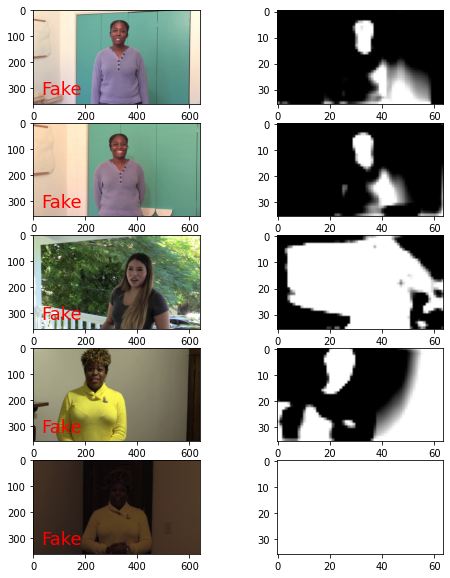

In [80]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt

def visualize_attn_map(
    config: Config,
    model: Model,
    dataloader: DataLoader,
    n_sample: int,
):
    """
    extract SABlock features
    """
    assert n_sample <= config.batch_size

    model.eval()
    plt.figure(figsize=(8, 2 * n_sample))

    x, y = list(dataloader)[0]
    x, y = x.to(device), y.to(device)

    for batch_idx in range(n_sample):
        # image
        x_i, y_i = test_dataset[batch_idx]
        # (C, H, W) -> (H, W, C)
        x_i = x_i.permute(1, 2, 0).numpy()
        ax = plt.subplot(n_sample, 2, batch_idx * 2 + 1)
        ax.text(0.05, 0.1, 'Fake' if y_i == 0 else 'Real', fontsize=18, transform=ax.transAxes, color='red')
        plt.imshow(x_i)

        _ = model(x)

        # attention weight map
        # net[3]: SABlock
        # size: (B, C, H, W) = (32, 1, 36, 64)
        attn = model.net[3].features[0]
        # first batch (B=0, C=0, H, W)
        attn = attn[batch_idx, 0, :, :].detach().cpu().numpy()
        im = Image.fromarray(attn)
        plt.subplot(n_sample, 2, batch_idx * 2 + 2)
        plt.imshow(im)

        if batch_idx == n_sample - 1:
            break

    plt.show()

visualize_attn_map(config, model, test_dataloader, 5)